In [1]:
from functools import cache
from keybert import KeyBERT
import numpy as np
import pandas as pd

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

@cache
def create_embeddings(texts):
    try : 
        return np.array(kw_model.extract_embeddings(texts)[0][0])
    except:
        return np.zeros(384)

In [2]:
df = pd.read_csv('connections_clean.csv')

label = []
word = []

for idx, row in df.iterrows():
    for i in range(1, 5):
        word.append(row[f'w{i}'])
    label.extend([idx] * 4)

finished_df = pd.DataFrame({'label': label, 'word': word})
finished_df['embedding'] = finished_df['word'].apply(create_embeddings)
finished_df['puzzle'] = np.arange(len(finished_df)) // 16
finished_df.head()

,label,word,embedding,puzzle
0,0,ANNIVERSARY,"[-0.06276984, 0.10821476, 0.047664665, -0.0253...",0
1,0,BIRTHDAY,"[-0.084567346, 0.11157629, -0.006238818, 0.041...",0
2,0,SHOWER,"[-0.004404458, 0.015580897, 0.112289116, 0.019...",0
3,0,WEDDING,"[-0.016065089, 0.090614215, 0.003278323, 0.038...",0
4,1,BARS,"[-0.010722448, 0.019358307, -0.021829613, 0.01...",0


In [28]:
NUM_DATA_PER_PUZZLE = 200

X = []
Y = []

for idx, i in finished_df.groupby('puzzle'):
    for _ in range(NUM_DATA_PER_PUZZLE - len(i)):
        stacked = []
        sample = i.sample(n = 16, replace = False)
        for embedding in sample['embedding']:
            stacked.extend(embedding)
        X.append(stacked)
        if sample['label'].iloc[0] == sample['label'].iloc[1]:
            Y.append(1)
        else: 
            Y.append(0)

In [29]:
from sklearn.model_selection import train_test_split

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam # legacy faster on m2 macs
import tensorflow_addons as tfa

model = Sequential([
    Dense(512, activation='relu', input_shape=(16*384,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

Epoch 1/100
2342/2342 [==============================] - 20s 8ms/step - loss: 0.7187 - accuracy: 0.6340 - val_loss: 0.5158 - val_accuracy: 0.7990
Epoch 2/100
2342/2342 [==============================] - 12s 5ms/step - loss: 0.5661 - accuracy: 0.7590 - val_loss: 0.5058 - val_accuracy: 0.7990
Epoch 3/100
2342/2342 [==============================] - 12s 5ms/step - loss: 0.5339 - accuracy: 0.7892 - val_loss: 0.5036 - val_accuracy: 0.7990
Epoch 4/100
2342/2342 [==============================] - 12s 5ms/step - loss: 0.5203 - accuracy: 0.7983 - val_loss: 0.5028 - val_accuracy: 0.7990
Epoch 5/100
2342/2342 [==============================] - 13s 6ms/step - loss: 0.5117 - accuracy: 0.8010 - val_loss: 0.5025 - val_accuracy: 0.7990
Epoch 6/100
2342/2342 [==============================] - 16s 7ms/step - loss: 0.5075 - accuracy: 0.8015 - val_loss: 0.5020 - val_accuracy: 0.7990
Epoch 7/100
2342/2342 [==============================] - 13s 5ms/step - loss: 0.5045 - accuracy: 0.8016 - val_loss: 0.5023 -

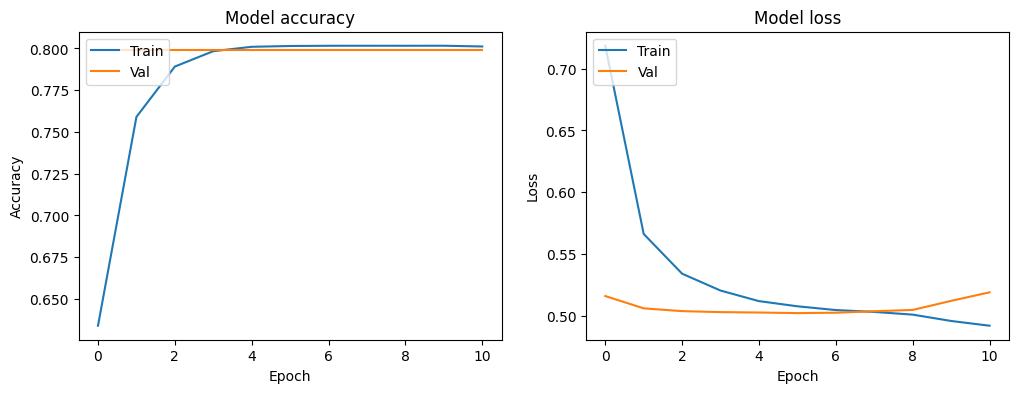

2928/2928 [==============================] - 5s 2ms/step - loss: 0.4903 - accuracy: 0.8011
Train accuracy: 0.8010803461074829
732/732 [==============================] - 1s 2ms/step - loss: 0.5087 - accuracy: 0.8042
Val accuracy: 0.8042271733283997


In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

print(f'Train accuracy: {model.evaluate(X_train, Y_train)[1]}')
print(f'Val accuracy: {model.evaluate(X_test, Y_test)[1]}')

In [34]:
same = 0 
for i in model.predict(X_test):
    if i[0] > 0.5:
        same += 1

print(f'Predicted same: {same} out of {len(Y_test)}')


732/732 [==============================] - 1s 2ms/step
Predicted same: 0 out of 23420
